In [42]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from tqdm import tqdm

In [43]:
PROJECT_ROOT = os.path.abspath("..")
PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
TRAIN_CSV = os.path.join(PROCESSED_PATH, "train.csv")
VAL_CSV = os.path.join(PROCESSED_PATH, "val.csv")
TEST_CSV = os.path.join(PROCESSED_PATH, "test.csv")

In [44]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

le = LabelEncoder()
le.fit(train_df["label"])
train_df["label_encoded"] = le.transform(train_df["label"])
val_df["label_encoded"] = le.transform(val_df["label"])
test_df["label_encoded"] = le.transform(test_df["label"])

In [45]:
IMAGE_SIZE = (48, 48)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

In [46]:
def load_images(df, transform=None):
    images = []
    labels = []
    for row in tqdm(df.itertuples(), total=len(df)):
        try:
            img = Image.open(row.filepath)
            if transform:
                img = transform(img)
            images.append(img)
            labels.append(row.label_encoded)
        except:
            continue
    return torch.stack(images), torch.tensor(labels)

In [47]:
X_train, y_train = load_images(train_df, transform)

100%|██████████| 2474/2474 [00:01<00:00, 1851.98it/s]


In [48]:
X_val, y_val = load_images(val_df, transform)

100%|██████████| 530/530 [00:00<00:00, 1946.33it/s]


In [49]:
X_test, y_test = load_images(test_df, transform)

100%|██████████| 531/531 [00:00<00:00, 1814.57it/s]


In [50]:
X_train = X_train.float() / 255.0
X_val = X_val.float() / 255.0
X_test = X_test.float() / 255.0

In [51]:
summary = {
    "train_images": X_train.shape,
    "train_labels": y_train.shape,
    "val_images": X_val.shape,
    "val_labels": y_val.shape,
    "test_images": X_test.shape,
    "test_labels": y_test.shape,
    "num_classes": len(le.classes_)
}

print(summary)

{'train_images': torch.Size([2474, 1, 48, 48]), 'train_labels': torch.Size([2474]), 'val_images': torch.Size([530, 1, 48, 48]), 'val_labels': torch.Size([530]), 'test_images': torch.Size([531, 1, 48, 48]), 'test_labels': torch.Size([531]), 'num_classes': 2}


In [52]:
np.save(os.path.join(PROCESSED_PATH, "X_train.npy"), X_train)
np.save(os.path.join(PROCESSED_PATH, "y_train.npy"), y_train)
np.save(os.path.join(PROCESSED_PATH, "X_val.npy"), X_val)
np.save(os.path.join(PROCESSED_PATH, "y_val.npy"), y_val)
np.save(os.path.join(PROCESSED_PATH, "X_test.npy"), X_test)
np.save(os.path.join(PROCESSED_PATH, "y_test.npy"), y_test)

In [53]:
X_train_loaded = np.load(os.path.join(PROCESSED_PATH, "X_train.npy"))
y_train_loaded = np.load(os.path.join(PROCESSED_PATH, "y_train.npy"))
X_val_loaded = np.load(os.path.join(PROCESSED_PATH, "X_val.npy"))
y_val_loaded = np.load(os.path.join(PROCESSED_PATH, "y_val.npy"))
X_test_loaded = np.load(os.path.join(PROCESSED_PATH, "X_test.npy"))
y_test_loaded = np.load(os.path.join(PROCESSED_PATH, "y_test.npy"))

In [54]:
check1_total_images = X_train_loaded.shape[0] + X_val_loaded.shape[0] + X_test_loaded.shape[0]
check2_unique_labels = len(np.unique(y_train_loaded))
check3_pixel_min = X_train_loaded.min()
check4_pixel_max = X_train_loaded.max()
check5_class_distribution = {i: int(np.sum(y_train_loaded == i)) for i in np.unique(y_train_loaded)}

In [55]:
post_save_summary = {
    "total_images_across_splits": check1_total_images,
    "num_unique_labels_train": check2_unique_labels,
    "min_pixel_value_train": check3_pixel_min,
    "max_pixel_value_train": check4_pixel_max,
    "train_class_distribution": check5_class_distribution
}

print("========== POST-SAVE DATA CHECKS ==========")
for key, value in post_save_summary.items():
    print(f"{key}: {value}")
print("===========================================")

========== POST-SAVE DATA CHECKS ==========
total_images_across_splits: 3535
num_unique_labels_train: 2
min_pixel_value_train: 0.0
max_pixel_value_train: 0.003921568859368563
train_class_distribution: {np.int64(0): 752, np.int64(1): 1722}


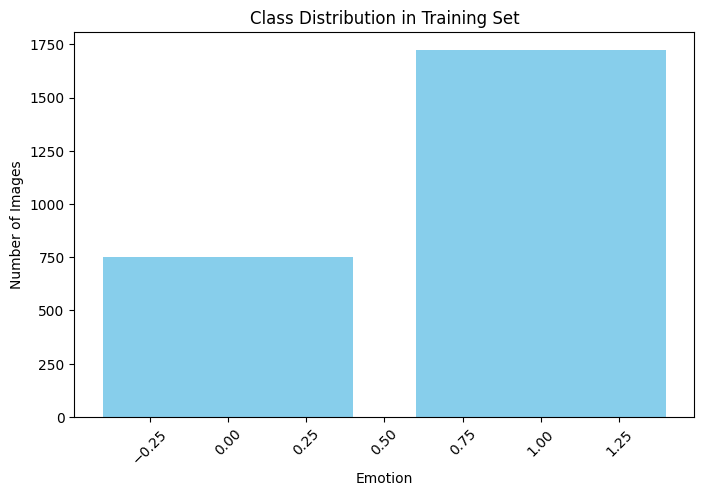

In [56]:
import matplotlib.pyplot as plt

labels = le.inverse_transform(np.unique(y_train_loaded))
counts = [np.sum(y_train_loaded == i) for i in np.unique(y_train_loaded)]

plt.figure(figsize=(8,5))
plt.bar(labels, counts, color='skyblue')
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

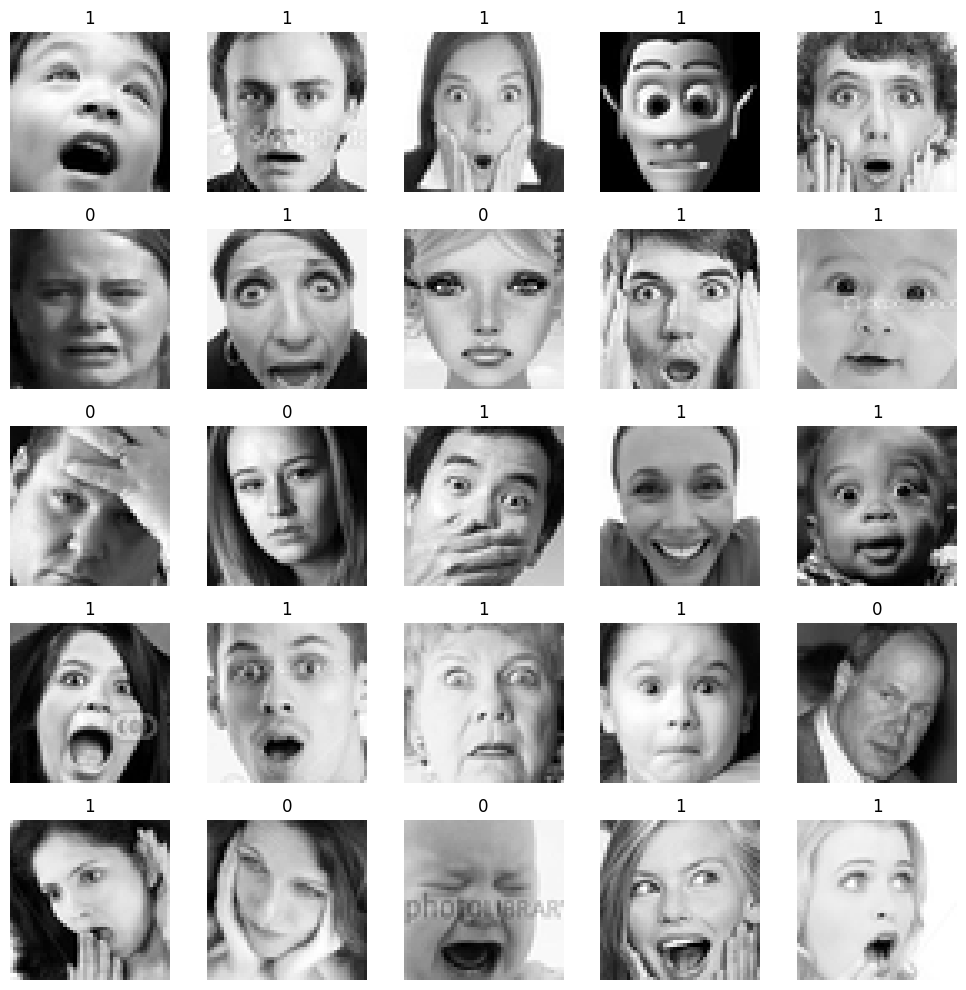

In [57]:
sample_indices = np.random.choice(len(X_train_loaded), 25, replace=False)
fig, axes = plt.subplots(5,5, figsize=(10,10))
for ax, idx in zip(axes.flatten(), sample_indices):
    ax.imshow(X_train_loaded[idx].squeeze(), cmap='gray')
    ax.set_title(le.inverse_transform([y_train_loaded[idx]])[0])
    ax.axis('off')
plt.tight_layout()
plt.show()

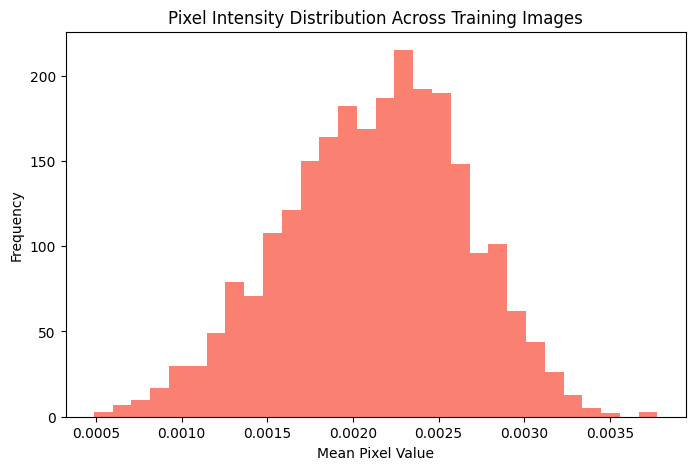

In [58]:

pixel_means = X_train_loaded.mean(axis=(1,2,3))
plt.figure(figsize=(8,5))
plt.hist(pixel_means, bins=30, color='salmon')
plt.title("Pixel Intensity Distribution Across Training Images")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [59]:
val_labels = le.inverse_transform(np.unique(y_val_loaded))
val_counts = [np.sum(y_val_loaded == i) for i in np.unique(y_val_loaded)]
test_labels = le.inverse_transform(np.unique(y_test_loaded))
test_counts = [np.sum(y_test_loaded == i) for i in np.unique(y_test_loaded)]

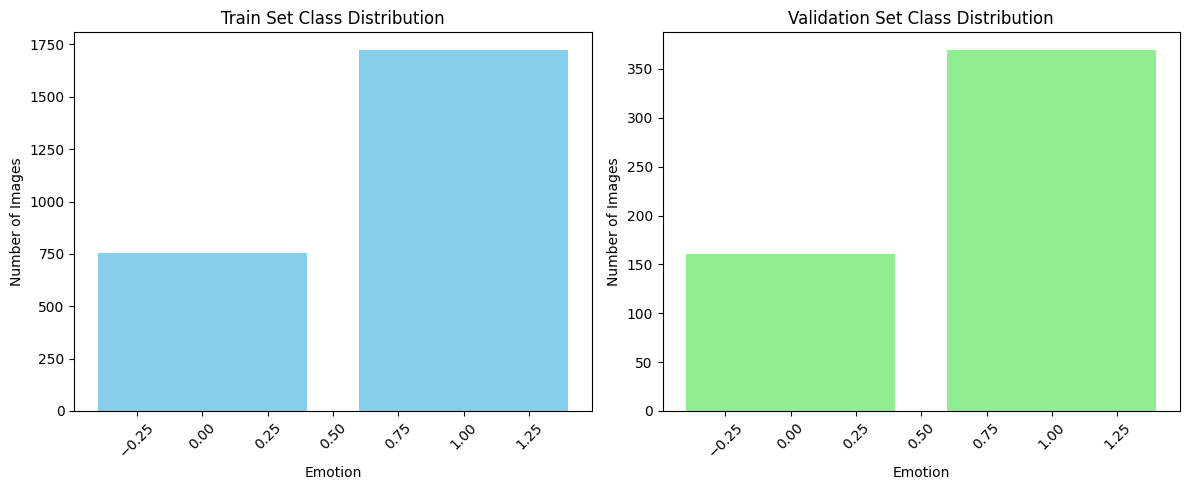

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].bar(labels, counts, color='skyblue')
axes[0].set_title("Train Set Class Distribution")
axes[0].set_xlabel("Emotion")
axes[0].set_ylabel("Number of Images")
axes[0].tick_params(axis='x', rotation=45)
axes[1].bar(val_labels, val_counts, color='lightgreen')
axes[1].set_title("Validation Set Class Distribution")
axes[1].set_xlabel("Emotion")
axes[1].set_ylabel("Number of Images")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [61]:
avg_pixel_per_class = []
for i in np.unique(y_train_loaded):
    avg_pixel_per_class.append(X_train_loaded[y_train_loaded==i].mean())

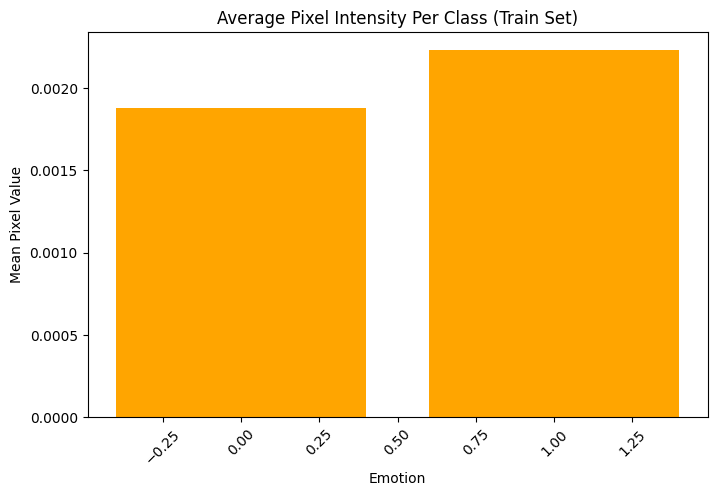

In [62]:
plt.figure(figsize=(8,5))
plt.bar(labels, avg_pixel_per_class, color='orange')
plt.title("Average Pixel Intensity Per Class (Train Set)")
plt.xlabel("Emotion")
plt.ylabel("Mean Pixel Value")
plt.xticks(rotation=45)
plt.show()

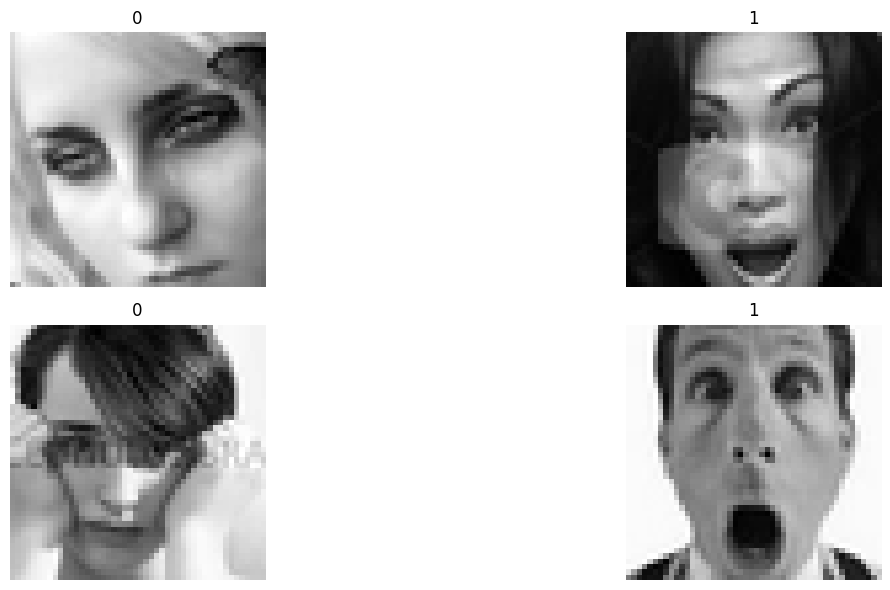

In [63]:
sample_class_indices = {i: np.where(y_train_loaded==i)[0] for i in np.unique(y_train_loaded)}
fig, axes = plt.subplots(2, len(sample_class_indices), figsize=(16,6))
for j, (cls, indices) in enumerate(sample_class_indices.items()):
    idx_sample = np.random.choice(indices, 2, replace=False)
    for i, idx in enumerate(idx_sample):
        axes[i,j].imshow(X_train_loaded[idx].squeeze(), cmap='gray')
        axes[i,j].set_title(le.inverse_transform([cls])[0])
        axes[i,j].axis('off')
plt.tight_layout()
plt.show()

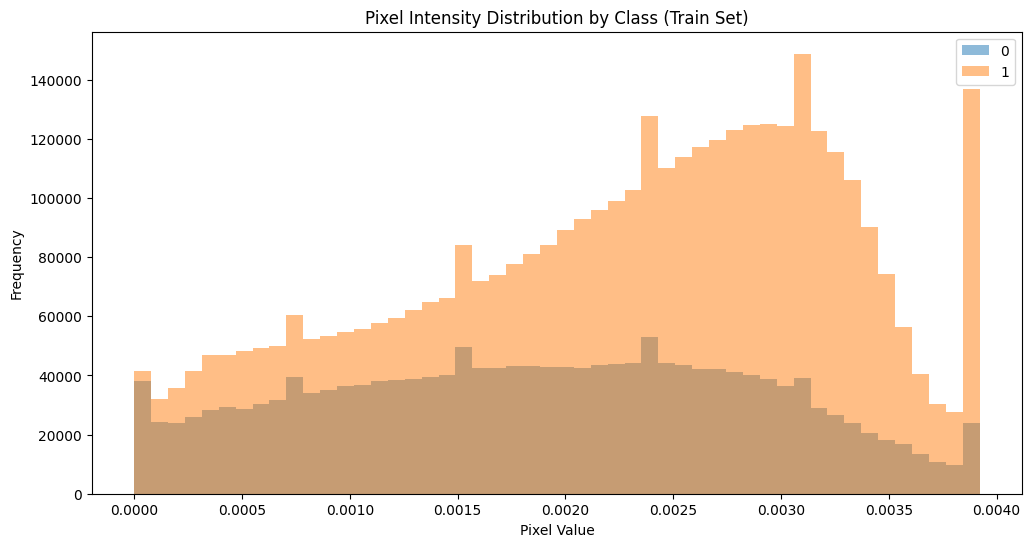

In [64]:
plt.figure(figsize=(12,6))
for i, cls in enumerate(np.unique(y_train_loaded)):
    pixels = X_train_loaded[y_train_loaded==cls].reshape(-1)
    plt.hist(pixels, bins=50, alpha=0.5, label=le.inverse_transform([cls])[0])
plt.title("Pixel Intensity Distribution by Class (Train Set)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

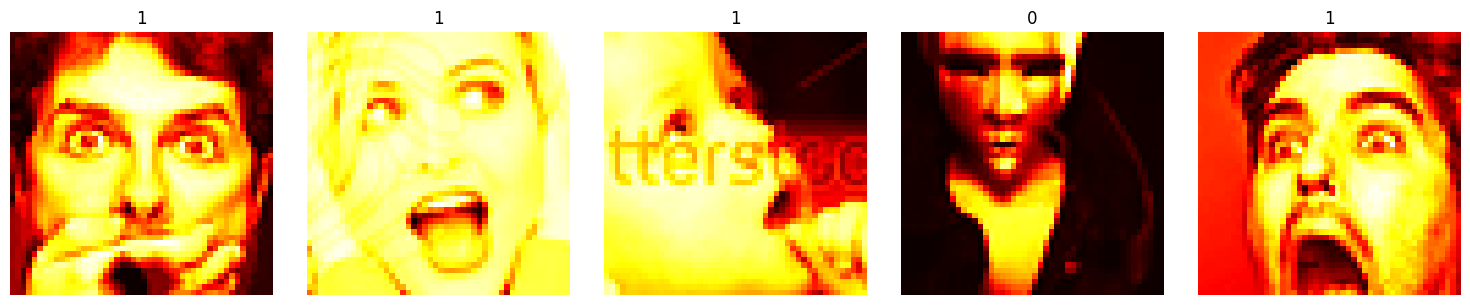

In [66]:
heat_idx = np.random.choice(len(X_train_loaded), 5, replace=False)
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i, idx in enumerate(heat_idx):
    axes[i].imshow(X_train_loaded[idx].squeeze(), cmap='hot')
    axes[i].set_title(le.inverse_transform([y_train_loaded[idx]])[0])
    axes[i].axis('off')
plt.tight_layout()
plt.show()